# **CNN: Visual Car Models Classification Model**

![](https://www.howardsgroup.co.uk/assets/media/evolutionofthecar_1.jpg)



**The goal of this project to build car image classification model to classify different car models**

In [1]:
import shutil
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg'
%matplotlib inline


print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['comb-images', 'submisn', 'sf-dl-car-classification', 'best-model-1', 'bestmodel']
Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.5
Tensorflow   : 2.6.3
Keras        : 2.6.0


In [2]:
!pip freeze > requirements.txt

# Set Up

In [3]:
# Setup functions and important constants

EPOCHS = 5  # number of epochs
BATCH_SIZE = 64  
LR = 1e-4
VAL_SPLIT = 0.15  # train test split ratio

CLASS_NUM = 10  # number of car models
IMG_SIZE = 224  # image width
IMG_CHANNELS = 3   #  RGB 3 channels
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)


DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/"  
COMB_PATH = '../input/comb-images/additional_images'

In [4]:


RANDOM_SEED = 42 # see value
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

In [5]:

# The function below builds data generator for training and desting data.

def data_preprocess_gen(train_path, test_path, IMG_SIZE_w, IMG_SIZE_h, BATCH_SIZE, train_datagen, test_datagen):

    train_generator = train_datagen.flow_from_directory(
        train_path,      # image folder directory
        target_size=(round(IMG_SIZE_w), IMG_SIZE_h),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True, seed=RANDOM_SEED,
        subset='training')  # set as training data

    test_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(round(IMG_SIZE_w), IMG_SIZE_h),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        subset='validation')  # set as validation data

    test_sub_generator = test_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        directory=test_path,
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(round(IMG_SIZE_w), IMG_SIZE_h),
        batch_size=BATCH_SIZE,)

    return train_generator, test_generator, test_sub_generator



train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,  # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)


# The function below builds training graphics.

def learning_charts(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# This function builds confusion matrix

def built_conf_matrix(model, generator):

    labls = []
    for i in range(len(generator)):
        bach = list(np.argmax(generator[i][1], axis=1))
        labls += bach

    Y_pred = model.predict(generator)
    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    # Convert validation observations to one hot vectors
    Y_true = np.array(labls)
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    # plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))

    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,
                cmap="viridis", linecolor="blue", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


# EDA

In [7]:
display(train_df.info())
print('')
train_df.Category.value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


None

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [8]:


# Given data contains 15561 images for training. It's not a lot to build a good model. Augmentaion
# is very helpful feature in this case.

# Ten car models are almost equally represented in this data.

<AxesSubplot:>

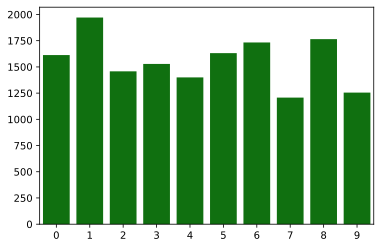

In [9]:
sns.barplot(y=train_df.Category.value_counts().values,
           x=train_df.Category.value_counts().index,
           color='g')

In [10]:
# This table shows almost equal number of all car models in data

In [11]:

# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

['test_upload', 'train']


Image examples (random sample)


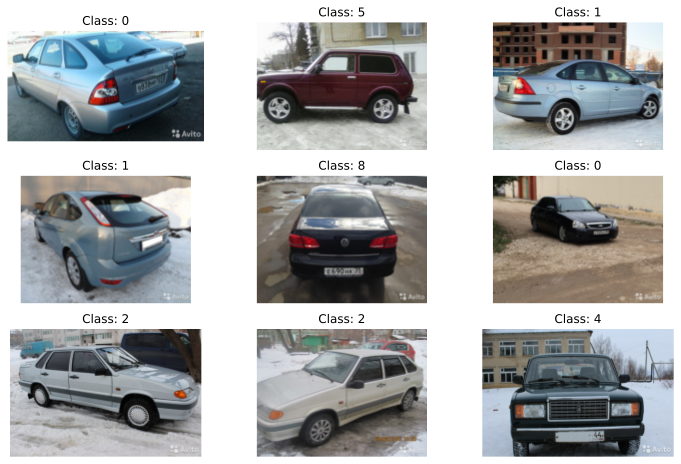

In [12]:

print('Image examples (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

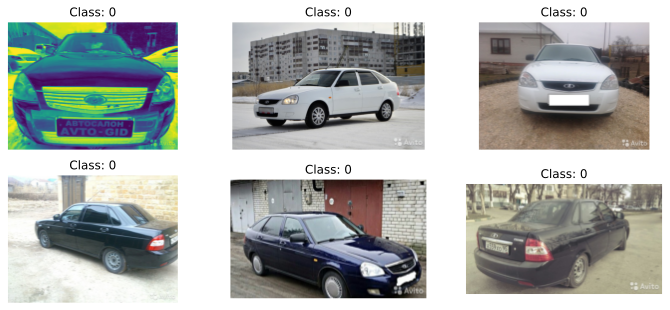

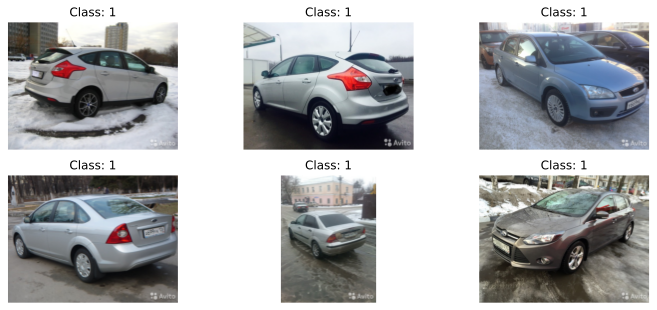

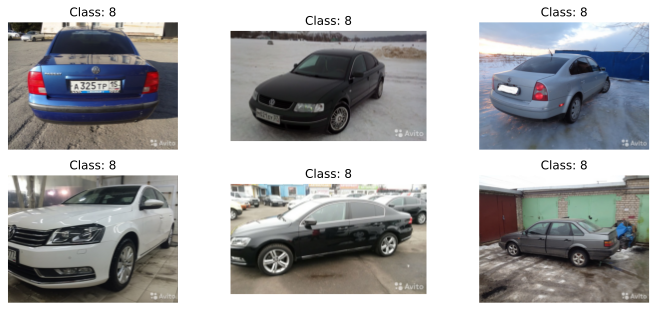

In [13]:
# Image examples of some models

# plt.figure(figsize=(12,8))
car_models = [0, 1, 8]

for car in car_models:

    plt.figure(figsize=(12, 8))
    random_image = train_df[train_df.Category == car].sample(n=6)
    random_image_paths = random_image['Id'].values
    random_image_cat = random_image['Category'].values

    for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
        plt.subplot(3, 3, index+1)
        plt.imshow(im)
        plt.title('Class: '+str(random_image_cat[index]))
        plt.axis('off')
    plt.show()

In [14]:
#Even image examples contain some images with noticebly different size ratios.

In [15]:
# Image size statistics

def image_size_collection(row):
    img_name = row['Id']
    cat = row['Category']

    paz = PATH + 'train/' + str(cat) + '/' + img_name
    image = PIL.Image.open(paz)

    return image.size[0], image.size[1]


train_df[['widz', 'heigt']] = train_df[['Id', 'Category']].apply(
    image_size_collection, axis=1, result_type='expand')

In [16]:
train_df['ratio'] = train_df['widz'] / train_df['heigt']

print('Width')
display(train_df['widz'].describe())
print('')

print('Height')
display(train_df['heigt'].describe())
print('')

print('Width to Height ratio')
display(train_df['ratio'].describe())
print('')

Width


count    15561.000000
mean       607.411606
std         90.278909
min        130.000000
25%        640.000000
50%        640.000000
75%        640.000000
max        640.000000
Name: widz, dtype: float64


Height


count    15561.000000
mean       445.085984
std         52.803775
min         97.000000
25%        385.000000
50%        480.000000
75%        480.000000
max        480.000000
Name: heigt, dtype: float64


Width to Height ratio


count    15561.000000
mean         1.390796
std          0.290972
min          0.558333
25%          1.333333
50%          1.333333
75%          1.628499
max          2.700422
Name: ratio, dtype: float64

In [17]:


# The median and mean for images' heigt and width are almost equal. They are 640 on 480. 
# There are few ouliers, I will experiment with deleting them.

# Base Model

In [18]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

2022-08-08 22:14:40.634584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:14:40.760020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:14:40.760792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:14:40.761949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 1s 0us/step


In [19]:
# Set and new for model (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:

# Augmentation generator


train_path = PATH + 'train/'
test_path = PATH + 'test_upload/'

train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
                                                                          test_path, IMG_SIZE, IMG_SIZE,
                                                                          BATCH_SIZE, train_datagen, test_datagen)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [21]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=15, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [22]:
# training process

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-08 22:14:49.990291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-08-08 22:14:56.036197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


207/207 [==============================] - 308s 1s/step - loss: 0.8662 - accuracy: 0.6947 - val_loss: 0.3316 - val_accuracy: 0.8781

Epoch 00001: saving model to best_model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
207/207 [==============================] - 293s 1s/step - loss: 0.1968 - accuracy: 0.9299 - val_loss: 0.2453 - val_accuracy: 0.9068

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
207/207 [==============================] - 294s 1s/step - loss: 0.1084 - accuracy: 0.9601 - val_loss: 0.2332 - val_accuracy: 0.9214

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
207/207 [==============================] - 294s 1s/step - loss: 0.0792 - accuracy: 0.9730 - val_loss: 0.2428 - val_accuracy: 0.9210

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
207/207 [==============================] - 293s 1s/step - loss: 0.0535 - accuracy: 0.9815 - val_loss: 0.2431 - val_accuracy: 0.9339

Epoch 00005: saving model to best_model.hdf5


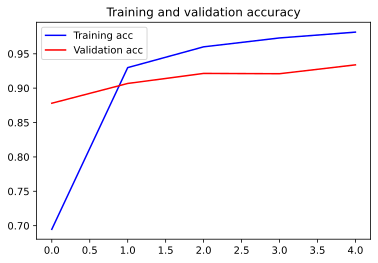

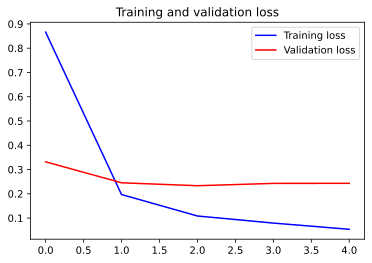

In [23]:
learning_charts(history)

In [24]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1] *100))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


37/37 [==============================] - 37s 994ms/step - loss: 0.2440 - accuracy: 0.9309
Accuracy: 93.09%


**After training Base Model on testing images got 92.96%**

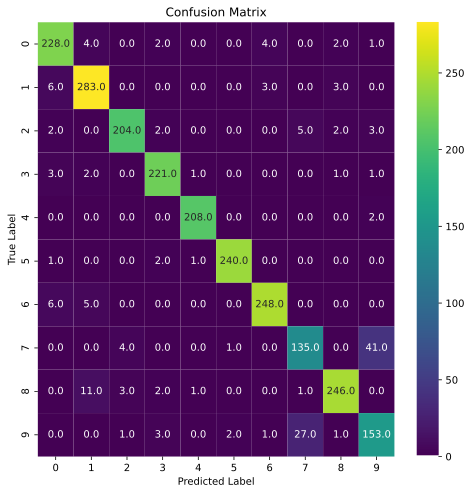

In [25]:
built_conf_matrix(model, test_generator)

# Images




**I found some images were very narrow, very dark, some photos of the interior of the car 
instead of exterior. Some of these pictures I deleted or edited some, especially if the photo contained several cars from 
different class I had to classify. Then I decided to add  11,000 more photos for training. Images were taken from the Internet 
car market. For augmentation I used the albumentations library. This library gives more opportunities for augmentation of pictures. I experimented with albumentation parameters to find good combination for my images.**

In [26]:
# albumentations library installation

!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-2zl1v9se
  Running command git clone --filter=blob:none --quiet https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-2zl1v9se
  Resolved https://github.com/mjkvaak/ImageDataAugmentor to commit 9f16ebd3e667cc16cde49f1ec1e5211e7962cd5c
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 KB 553.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.5 MB/s eta 0:00:00
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29644 sha256=8488fcc5d514432df06f7c3bff8d8c379f602846b3b7950699b65f451252a270
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtrt1vg4/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.

In [27]:
import albumentations as a
from ImageDataAugmentor.image_data_augmentor import *

In [28]:
augmentations = a.Compose([
    
    a.Blur(p=0.05),
    a.GaussNoise(p=0.05),
    
    a.ShiftScaleRotate(always_apply=False, p=.75,
                       shift_limit=(-0.11, 0.11),
                       scale_limit=(-0.25, 0.25),
                       rotate_limit=(-11, 11),
                       interpolation=1,
                       border_mode=4,
                       value=(0, 0, 0),
                       mask_value=None),

    a.RandomBrightness(limit=0.3, p=0.5),

    

    a.HorizontalFlip(),
    a.HueSaturationValue(),  
    a.RGBShift(),
    a.JpegCompression(p=0.2, quality_lower=70, quality_upper=100),
    a.ISONoise(p=0.3, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
    a.ImageCompression(p=0.2, quality_lower=80,
                       quality_upper=100, compression_type=0),
    a.MultiplicativeNoise(always_apply=False, p=0.12, multiplier=(
        0.85, 1.15), per_channel=True, elementwise=True),
    a.OpticalDistortion(always_apply=False, p=0.15, distort_limit=(-0.30000001192092896, 0.30000001192092896),
                        shift_limit=(-0.05000000074505806, 0.05000000074505806), interpolation=4, border_mode=0, value=(0, 0, 0), mask_value=None),

    a.FancyPCA(alpha=0.1,  always_apply=False,  p=0.5),
    a.Resize(round(1.3 * IMG_SIZE), IMG_SIZE),

    
    a.OneOf([
        a.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        a.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5)
])


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:780: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  FutureWarning,


In [29]:
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=augmentations, 
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1./255)

In [30]:
train_path = COMB_PATH
test_path = PATH + 'test_upload/'

# Learning Rate and Optimizer

In [31]:
# Learning rate and optimizer search


# optimizer_list = ['RMSprop', 'Adam', 'Adadelta', 'Adamax']

# lr_list = [0.00006, 0.0001, 0.0002, 0.0005]


# for opt in optimizer_list:

#     for l_rate in lr_list:

#         print(opt)
#         print(l_rate)

#         base_model = Xception(weights='imagenet',
#                               include_top=False, input_shape=input_shape)

#         x = base_model.output
#         x = GlobalAveragePooling2D()(x)
#         # let's add a fully-connected layer
#         #x = BatchNormalization()(x)
#         x = Dense(256, activation='relu')(x)
#         #x = BatchNormalization()(x)
#         x = Dropout(0.25)(x)
#         # and a logistic layer -- let's say we have 10 classes
#         predictions = Dense(CLASS_NUM, activation='softmax')(x)

#         # this is the model we will train
#         model_lr = Model(inputs=base_model.input, outputs=predictions)
#         model_lr.compile(loss="categorical_crossentropy", optimizer=getattr(
#             optimizers, opt)(lr=l_rate), metrics=["accuracy"])

#         train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
#                                                                                   test_path, IMG_SIZE, IMG_SIZE,
#                                                                                   BATCH_SIZE, train_datagen, test_datagen)

#         checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
#                                      'val_accuracy'], verbose=1, mode='max')
#         earlystop = EarlyStopping(
#             monitor='val_accuracy', patience=15, restore_best_weights=True)
#         callbacks_list = [checkpoint, earlystop]

#         history = model_lr.fit_generator(
#             train_generator,
#             steps_per_epoch=len(train_generator),
#             validation_data=test_generator,
#             validation_steps=len(test_generator),
#             epochs=3,
#             callbacks=callbacks_list
#         )

#         scores = model_lr.evaluate_generator(
#             test_generator, steps=len(test_generator), verbose=1)
#         print("Accuracy: %.2f%%" % (scores[1] * 100))
#         print('#############################')
#         print('#############################')

In [32]:
# There is the method to find good learning rate rate. You have to train the model on 
# large learning rate range and after it graph loss vs learning rate. Look for ranges
# with big rate of change on the graph


from keras.callbacks import Callback
import keras.backend as K


class LRFinder(Callback):

    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 

    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])

            lr_finder.plot_loss()
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''

    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations
        return self.min_lr + (self.max_lr-self.min_lr) * x

    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()

    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale("linear")
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [33]:
# The code below is for cyclical learning rate training

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''

    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / \
            (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * \
            (self.max_lr - self.min_lr) * \
            (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [34]:
lr_finder = LRFinder(min_lr=0.00004, max_lr=0.001, steps_per_epoch=344, epochs=3)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:333: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 21975 images belonging to 10 classes.
Found 3872 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:456: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
344/344 [==============================] - 716s 2s/step - loss: 0.7890 - accuracy: 0.7152 - val_loss: 0.4572 - val_accuracy: 0.8425

Epoch 00001: saving model to best_model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
344/344 [==============================] - 637s 2s/step - loss: 0.2687 - accuracy: 0.9027 - val_loss: 0.5201 - val_accuracy: 0.8468

Epoch 00002: saving model to best_model.hdf5
Epoch 3/3
344/344 [==============================] - 631s 2s/step - loss: 0.2649 - accuracy: 0.9044 - val_loss: 0.5230 - val_accuracy: 0.8345

Epoch 00003: saving model to best_model.hdf5


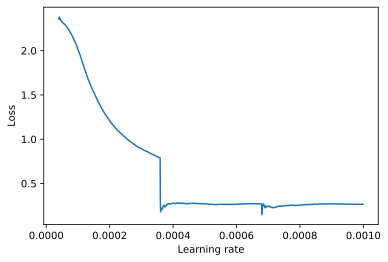

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


61/61 [==============================] - 90s 1s/step - loss: 0.5387 - accuracy: 0.8404
Accuracy: 84.04%


In [35]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)


x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model_lr = Model(inputs=base_model.input, outputs=predictions)
model_lr.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
                                                                          test_path, IMG_SIZE, IMG_SIZE,
                                                                          BATCH_SIZE, train_datagen, test_datagen)


checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=15, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, lr_finder]


history = model_lr.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=3,
    callbacks=callbacks_list
)


lr_finder.plot_loss()


scores = model_lr.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [36]:
# The graph shows good learning rate range is in 0.00009 to 0.0005

In [37]:
# Parameters for cyclical training

schedule = SGDRScheduler(min_lr= 0.00009,
                         max_lr=0.0005,
                         steps_per_epoch=np.ceil(344/64),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.4)

In [38]:
# Model training with cyclical learning rate

# base_model = Xception(weights='imagenet',
#                       include_top=False, input_shape=input_shape)


# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# #x = BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)
# #x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model_lr = Model(inputs=base_model.input, outputs=predictions)
# model_lr.compile(loss="categorical_crossentropy",
#                  optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


# train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
#                                                                           test_path, IMG_SIZE, IMG_SIZE,
#                                                                           BATCH_SIZE, train_datagen, test_datagen)


# checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
#                              'val_accuracy'], verbose=1, mode='max')
# earlystop = EarlyStopping(monitor='val_accuracy',
#                           patience=15, restore_best_weights=True)
# callbacks_list = [checkpoint, earlystop, schedule]


# history = model_lr.fit_generator(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=test_generator,
#     validation_steps=len(test_generator),
#     epochs=7,
#     callbacks=callbacks_list
# )

In [39]:
# built_conf_matrix(model_lr, test_generator)

In [40]:
# The result of cyclical learning rate model training is not satisfactory

# Layers and Model's Top

**Then I decided not to train some
layers. Especially first layers because they containe basic features for image recognition. The best result for my task I got
by not training first 4 layers of Xception net. I deleted Xception's top and experiments with building the top for my problem.
After some number of trials I selected 512 Dense layer with regularization l2, activation relu, drop out rate 0.5 and another 
dense layer with 10 neurons and activation softmax.**

In [41]:
# I tuned couple of Adam's parameters and beta_1 parameter with 0.87 value was getting me better result. 
# I trained my model based on Xception for 10 epoches with image size 224 by 224. Additionaly after 10 epoches 
# I trained model for 2 epoches with image size 280 by 280.


base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)


base_model.trainable = True

fine_tune_at = 5

for layer in base_model.layers[: fine_tune_at]:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = BatchNormalization()(x)
x = Dense(512, kernel_regularizer='l2', activation='relu')(x)
#x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model_layer = Model(inputs=base_model.input, outputs=predictions)
model_layer.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(
    lr=LR, beta_1=0.87), metrics=["accuracy"])


train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
                                                                          test_path, IMG_SIZE, IMG_SIZE,
                                                                          BATCH_SIZE, train_datagen, test_datagen)


checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=15, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


# history = model_layer.fit_generator(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=test_generator,
#     validation_steps=len(test_generator),
#     epochs=10,
#     callbacks=callbacks_list
# )

Found 21975 images belonging to 10 classes.
Found 3872 images belonging to 10 classes.
Found 6675 validated image filenames.


**Image size**

In [42]:
# Training model on images  1.3*280 on 280

IMG_SIZE = 280

train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
                                                                          test_path, 1.3 * IMG_SIZE, IMG_SIZE,
                                                                          BATCH_SIZE, train_datagen, test_datagen)


checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=15, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


# history = model_layer.fit_generator(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=test_generator,
#     validation_steps=len(test_generator),
#     epochs=2,
#     callbacks=callbacks_list
# )

Found 21975 images belonging to 10 classes.
Found 3872 images belonging to 10 classes.
Found 6675 validated image filenames.


In [43]:
# scores = model_layer.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy: %.2f%%" % (scores[1] *100))

In [44]:
# learning_charts(history)

In [45]:
# built_conf_matrix(model_layer, test_generator)

# EfficientNetV2M

In [46]:
pip install keras-efficientnet-v2

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 6.5 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77053 sha256=e77d66a8bd2964460281e3d2a17fbffd583203c1a44a61b421a7d9ae40ba5ac6
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.0
    Uninstalling wrapt-1.14.0:
      Successfully uninstalled wrapt-1.14.0
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attemptin

In [47]:
import keras_efficientnet_v2

In [48]:

# Then I experimented with couple of image nets and I chose EfficientNetV2M. It is several times larger 
# than Xception and so I was limited in the size of the batches. The training batch was 10. I spent a lot 
# of time to experiment with different parameters, number of layers, learning rates, image sizes and optimizers. 
# The best configuration for the top I found is a dense layer with 2048 neurons and a drop out rate of 0.5 , 
# activation relu plus another dense layer with 1024 neurons, activation relu,drop out rate of 0.36 (regularization 
# on both layers l2), final dense layer with 10 neurons and softmax activation. The first 4 layers of model 
# are not retrained, the size of the photos for training was 320 by 320. 

In [49]:
base_model = keras_efficientnet_v2.EfficientNetV2M(pretrained="imagenet21k-ft1k", num_classes=0,
                                                   input_shape=input_shape)


base_model.trainable = True

fine_tune_at = 4

for layer in base_model.layers[: fine_tune_at]:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(2048, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.36)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model_3 = Model(inputs=base_model.input, outputs=predictions)

219758592/219746704 [==============================] - 18s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-m-21k-ft1k.h5


In [50]:
IMG_SIZE = 320


train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path,
                                                                          test_path, IMG_SIZE, IMG_SIZE, 10,
                                                                          train_datagen, test_datagen)

Found 21975 images belonging to 10 classes.
Found 3872 images belonging to 10 classes.
Found 6675 validated image filenames.


In [51]:
checkpoint = ModelCheckpoint('best_model_Eff.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')

earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=15, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [52]:
model_3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(
    learning_rate=LR, beta_1=0.85), metrics=["accuracy"])

In [53]:
# history = model_3.fit_generator(
#         train_generator,
#         steps_per_epoch = len(train_generator),
#         validation_data = test_generator, 
#         validation_steps = len(test_generator),
#         epochs = 11,
#         callbacks = callbacks_list
# )

In [54]:
# learning_charts(history)

In [55]:
# model_3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(
#     learning_rate=(LR * 0.9), beta_1=0.85), metrics=["accuracy"])

In [56]:
# history = model_3.fit_generator(
#         train_generator,
#         steps_per_epoch = len(train_generator),
#         validation_data = test_generator, 
#         validation_steps = len(test_generator),
#         epochs = 2,
#         callbacks = callbacks_list
# )

In [57]:
# scores = model_3.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy: %.2f%%" % (scores[1] *100))

In [58]:
# built_conf_matrix(model_3, test_generator)

In [59]:
# The confusion matrix shows better results specially for model number 7 and 9. These
# are the most difficult models to tell apart even for a human, because they have noticeable
# difference in the shape of trunk. 

In [60]:
test_sub_generator.reset()
predictions = model_3.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


668/668 [==============================] - 71s 101ms/step


In [61]:
# filenames_with_dir = test_sub_generator.filenames
# submission = pd.DataFrame(
#     {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
# submission['Id'] = submission['Id'].replace('test_upload/', '')
#submission.to_csv('submission_55c.csv', index=False)
#print('Save submit')

In [62]:
# This model shows the best result for now 0.97318

# Retraining EfficientNetV2M including classified Test Images

In [63]:

# The model below is based on EfficientNetV2M model above additionally with test images. Since 
# I didn't have labels for them I used the labels I got from the last time I trained the model.

In [64]:
# The code below copies images to working directory where I can add additional images

source_dir = '../input/comb-images/additional_images'
destination_dir = "../working/car/trn"
shutil.copytree(source_dir, destination_dir)

'../working/car/trn'

In [65]:
submission = pd.read_csv('../input/submisn/submission_55c.csv')

In [66]:
submission['Category'] = submission['Category'].values.astype('str')

In [67]:
# The code below copies test images to working directory in different models' folders.
# Images that model above classified as number 7 and 9 will not be copied because of the
# high rate of error.


src_dir = '../working/car/test_upload/'
dest_dir = destination_dir + '/'


def sort_images(row):
    folder = row['Category']
    img_name = row['Id']

    if folder == '7' or folder == '9':
        return

    src = src_dir + img_name
    dst = dest_dir + folder + '/'

    shutil.copy(src, dst)


submission[['Id', 'Category']].apply(sort_images, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
6670    None
6671    None
6672    None
6673    None
6674    None
Length: 6675, dtype: object

In [68]:
# validation_split=0.01

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=augmentations, 
    seed=RANDOM_SEED,
    validation_split=0.01)

test_datagen = ImageDataAugmentor(rescale=1./255)

In [69]:
# preparing images for training

IMG_SIZE = 320

train_path = dest_dir

train_generator, test_generator, test_sub_generator = data_preprocess_gen(train_path, 
                                                                          test_path, IMG_SIZE, IMG_SIZE, 10, 
                                                                          train_datagen, test_datagen)

Found 31169 images belonging to 10 classes.
Found 311 images belonging to 10 classes.
Found 6675 validated image filenames.


In [70]:
# Model

base_model = keras_efficientnet_v2.EfficientNetV2M(pretrained="imagenet21k-ft1k", num_classes=0,
                                                   input_shape=input_shape)


base_model.trainable = True

fine_tune_at = 4

for layer in base_model.layers[: fine_tune_at]:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(2048, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.36)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model_3_ret = Model(inputs=base_model.input, outputs=predictions)

>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-m-21k-ft1k.h5


In [71]:
# lr_finder = LRFinder(min_lr=0.00004, max_lr=0.0005, steps_per_epoch=2677, epochs=1)

In [72]:
checkpoint = ModelCheckpoint('best_model_Eff.hdf5', monitor=[
                             'val_accuracy'], verbose=1, mode='max')

earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=15, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [73]:
model_3_ret.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(
    learning_rate=LR, beta_1=0.85), metrics=["accuracy"])

In [74]:
# Training model with learning rate 0.0001 12 for epochs

history = model_3_ret.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 12,
        callbacks = callbacks_list
)




Epoch 1/12
3117/3117 [==============================] - 1223s 385ms/step - loss: 22.2354 - accuracy: 0.7581 - val_loss: 14.9234 - val_accuracy: 0.9389

Epoch 00001: saving model to best_model_Eff.hdf5
Epoch 2/12
3117/3117 [==============================] - 1216s 390ms/step - loss: 10.0528 - accuracy: 0.9358 - val_loss: 6.1790 - val_accuracy: 0.9614

Epoch 00002: saving model to best_model_Eff.hdf5
Epoch 3/12
3117/3117 [==============================] - 1189s 382ms/step - loss: 4.0190 - accuracy: 0.9557 - val_loss: 2.4363 - val_accuracy: 0.9614

Epoch 00003: saving model to best_model_Eff.hdf5
Epoch 4/12
3117/3117 [==============================] - 1195s 383ms/step - loss: 1.5786 - accuracy: 0.9653 - val_loss: 1.0072 - val_accuracy: 0.9646

Epoch 00004: saving model to best_model_Eff.hdf5
Epoch 5/12
3117/3117 [==============================] - 1200s 385ms/step - loss: 0.6894 - accuracy: 0.9696 - val_loss: 0.4915 - val_accuracy: 0.9775

Epoch 00005: saving model to best_model_Eff.hdf5
Ep

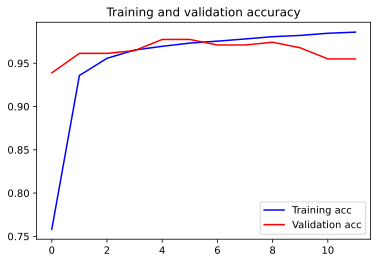

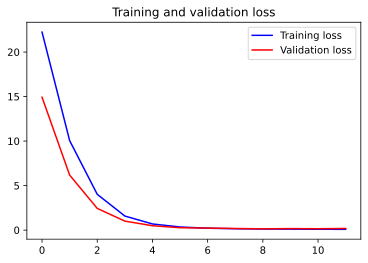

In [75]:
learning_charts(history)

In [76]:
model_3_ret.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(
    learning_rate=(LR * 0.9), beta_1=0.85), metrics=["accuracy"])

In [77]:
# additional training with learning rate 0.00009 for 2 epochs

history = model_3_ret.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 2,
        callbacks = callbacks_list
)

Epoch 1/2
3117/3117 [==============================] - 1219s 384ms/step - loss: 0.0845 - accuracy: 0.9857 - val_loss: 0.1925 - val_accuracy: 0.9678

Epoch 00001: saving model to best_model_Eff.hdf5
Epoch 2/2
3117/3117 [==============================] - 1199s 385ms/step - loss: 0.0752 - accuracy: 0.9883 - val_loss: 0.1424 - val_accuracy: 0.9743

Epoch 00002: saving model to best_model_Eff.hdf5


In [78]:
model_3_ret.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(
    learning_rate=(LR * 0.85), beta_1=0.85), metrics=["accuracy"])

In [79]:
# final training with learning rate 0.000085 for 1 epochs

history = model_3_ret.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 1,
        callbacks = callbacks_list
)

3117/3117 [==============================] - 1216s 383ms/step - loss: 0.0724 - accuracy: 0.9887 - val_loss: 0.1381 - val_accuracy: 0.9743

Epoch 00001: saving model to best_model_Eff.hdf5


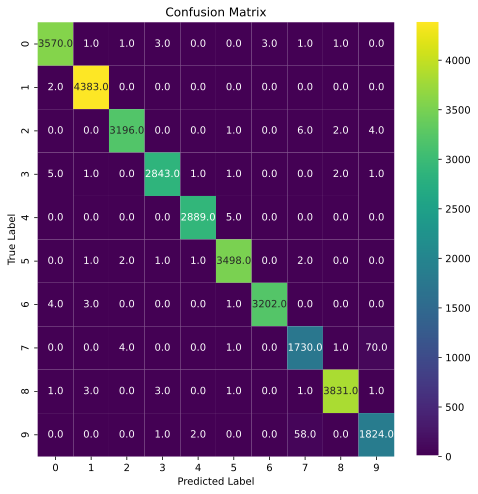

In [80]:
built_conf_matrix(model_3_ret, train_generator)

In [81]:
model_3_ret.load_weights('../input/bestmodel/best_model_Eff.hdf5')

In [82]:
test_sub_generator.reset()
predictions = model_3_ret.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


668/668 [==============================] - 69s 98ms/step


In [83]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_cars.csv', index=False)
print('Save submit')

Save submit


**After training the model with test images I got the 97.673% accuracy.**